## UNET CNN

In [76]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import KFold

In [77]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [78]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

Load EMNIST data with fixed permittivity

In [79]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./EMNIST_img/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train_full, fieldMNIST_test, targetMNIST_train_full, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=123)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train_full, targetMNIST_train_full, test_size=0.20, random_state=123)

Read 630 samples


In [27]:
np.max(targetMNIST_train_full[0])

1.0

In [15]:
[fieldMNIST_train.shape,targetMNIST_train.shape]

[(403, 24, 24, 1), (403, 28, 28, 1)]

In [80]:
fieldMNIST_train_f_padded = np.pad(fieldMNIST_train_full, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_train_padded = np.pad(fieldMNIST_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_val_padded = np.pad(fieldMNIST_val, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_test_padded = np.pad(fieldMNIST_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

In [81]:
[fieldMNIST_train_padded.shape,fieldMNIST_train_f_padded.shape]

[(403, 28, 28, 1), (504, 28, 28, 1)]

Load EMNIST data with added permittivity from Gaussian distribution

In [82]:
field_dif_perm, target_dif_perm, freq_dif_perm = readData(path = "./EMNIST_dif_perm/", getTargetName=False)

field_dif_perm_transformed = np.reshape(field_dif_perm, (field_dif_perm.shape[0], field_dif_perm.shape[1], field_dif_perm.shape[2], 1))
target_dif_perm_transformed = np.reshape(target_dif_perm, (target_dif_perm.shape[0], target_dif_perm.shape[1], target_dif_perm.shape[2], 1))

field_dif_perm_padded = np.pad(field_dif_perm_transformed, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

field_train_dif_perm, field_test_dif_perm, target_train_dif_perm, target_test_dif_perm= train_test_split(
    field_dif_perm_padded, target_dif_perm_transformed, test_size=0.20, random_state=123)

# field_dif_perm_padded = np.pad(field_dif_perm_transformed, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

field_dif_perm_transformed.shape

Read 630 samples


(630, 24, 24, 1)

Define U-Net

In [83]:
def unet_padded(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(28, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(56, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(56, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(128, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(128, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(56, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(56, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(56, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(28, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(28, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(28, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)


    model = Model(inputs=inputs, outputs=output)

    return model

In [87]:
inputMNIST_shape = fieldMNIST_train.shape[1:]
model_mnist_flatten = unet_with_flatten(inputMNIST_shape)
model_mnist_flatten.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 24, 24, 28)   280         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 24, 24, 28)  112         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 24, 24, 28)   0           ['batch_normalization_11[0]

Train on MNIST then test on shape (freq 1e9 and permitivity 2)

In [92]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
losses = []
val_losses = []
accuracy = []
val_accuracy = []
histories = []

acc_per_fold = []

   
Training for fold 1 ...
Epoch 1/80
51/51 [==============================] - 7s 80ms/step - loss: 0.6833 - accuracy: 0.6134 - val_loss: 0.6531 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 2/80
51/51 [==============================] - 4s 72ms/step - loss: 0.5968 - accuracy: 0.7014 - val_loss: 0.6284 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 3/80
51/51 [==============================] - 4s 74ms/step - loss: 0.5405 - accuracy: 0.7479 - val_loss: 0.6313 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 4/80
51/51 [==============================] - 4s 71ms/step - loss: 0.5041 - accuracy: 0.7709 - val_loss: 0.6546 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 5/80
51/51 [==============================] - 4s 72ms/step - loss: 0.4723 - accuracy: 0.7908 - val_loss: 0.6849 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 6/80
51/51 [==============================] - 4s 75ms/step - loss: 0.4435 - accuracy: 0.8100 - val_loss: 0.7093 - val_accuracy: 0.6806 - lr: 2.5000e-05
Epoch 7/80
51/51 [======

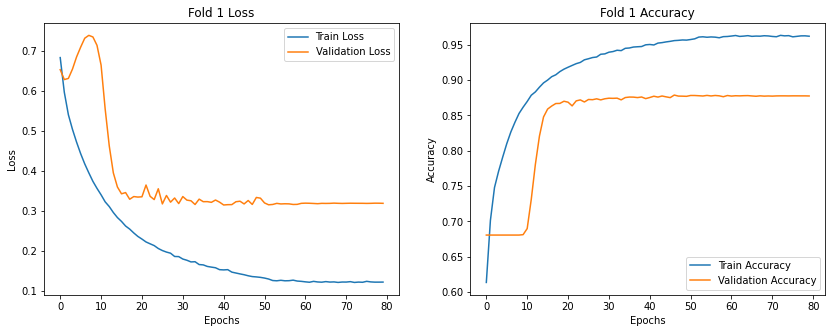

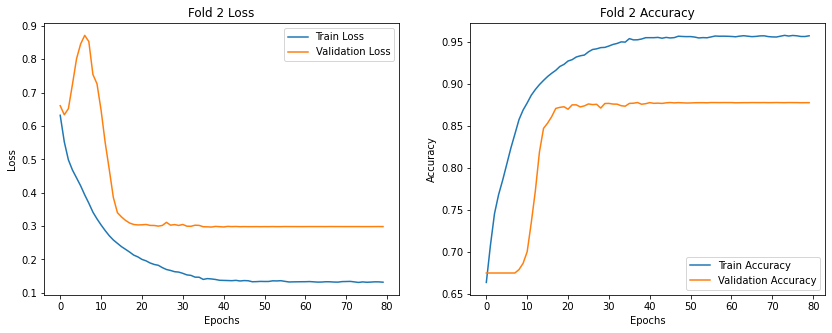

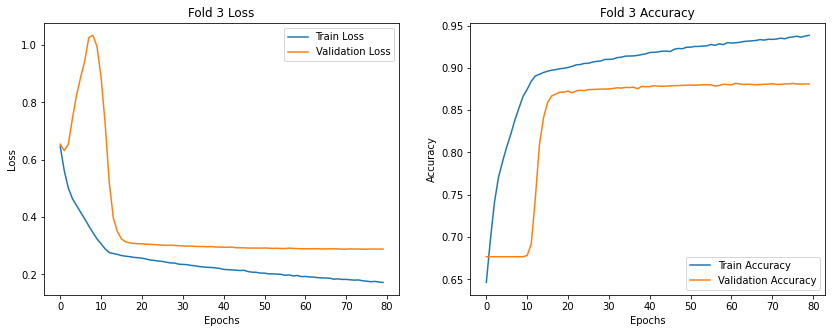

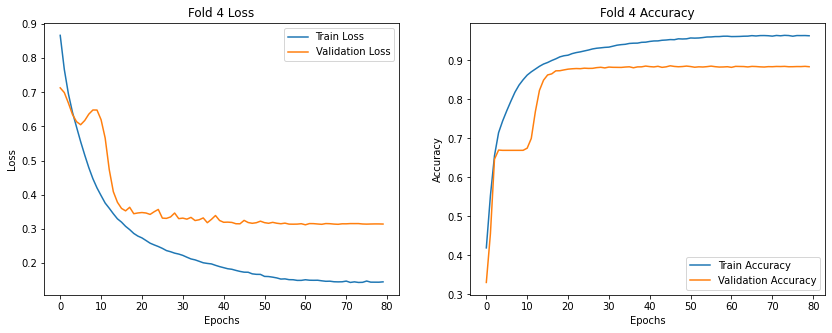

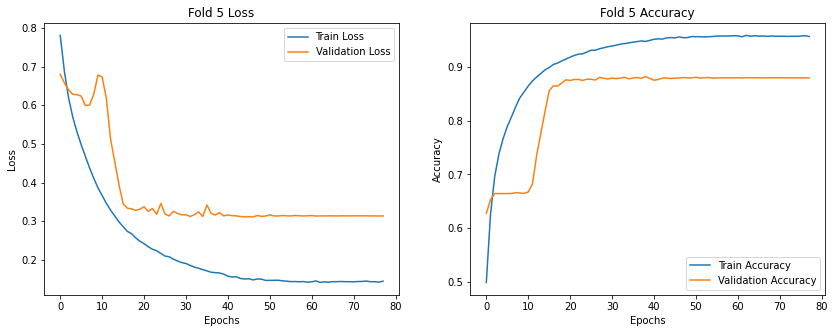

In [93]:
for train_index, val_index in kf.split(fieldMNIST_train_f_padded):
    print('   ')
    print(f'Training for fold {fold} ...')

    X_train, X_val = fieldMNIST_train_f_padded[train_index], fieldMNIST_train_f_padded[val_index]
    y_train, y_val = targetMNIST_train_full[train_index], targetMNIST_train_full[val_index]


    model1 = unet_padded(input_shape=X_train.shape[1:])

    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.5e-5), loss='binary_crossentropy', metrics='accuracy')
    early_stopping = EarlyStopping(monitor='loss', patience=15)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_delta=0.001, min_lr=1e-9)
    # checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
    history = model1.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=80, 
                        batch_size=8,
                        callbacks=[early_stopping,reduce_lr])
    histories.append(history.history)

    model1.save('models/model_fold_'+str(fold)+'.h5')   

    scores = model1.evaluate(fieldMNIST_test_padded, targetMNIST_test, verbose=0)
    acc_per_fold.append(scores[1] * 100)

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    losses.append((history.history['loss']))
    val_losses.append((history.history['val_loss']))
    accuracy.append((history.history['accuracy']))
    val_accuracy.append((history.history['val_accuracy']))

    fold += 1

In [94]:
acc_per_fold

[88.27542662620544,
 88.13573122024536,
 88.2642924785614,
 88.38374614715576,
 88.47687840461731]

In [95]:
best_model = load_model('models/model_fold_5.h5')
pred_test = best_model.predict(fieldMNIST_test_padded)
pred_train = best_model.predict(fieldMNIST_train_padded)
pred_dif_perm = best_model.predict(field_test_dif_perm)

4/4 [==============================] - 0s 93ms/step


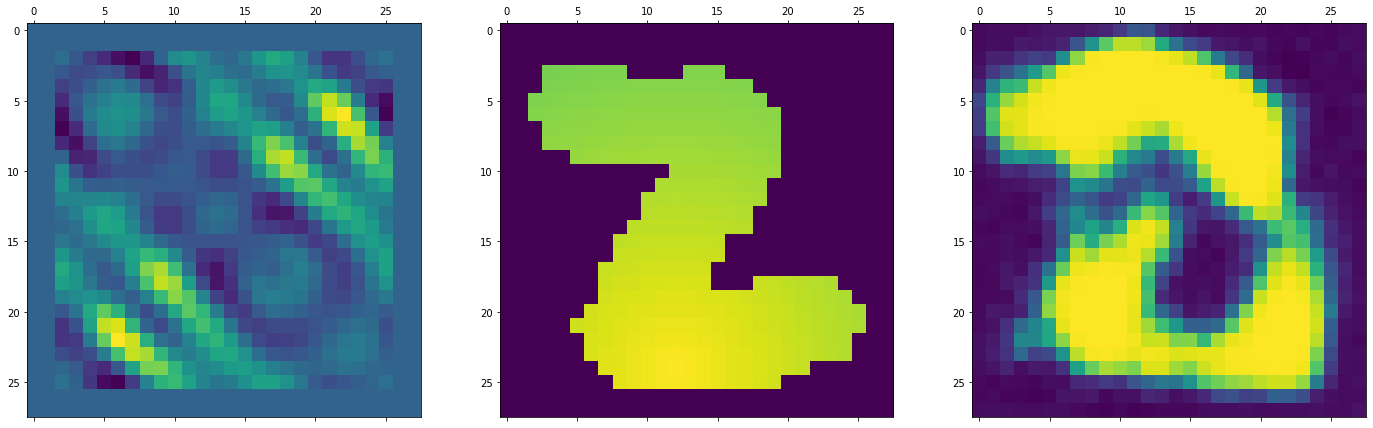

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(field_test_dif_perm[0])
axs[1].matshow(target_test_dif_perm[0])
axs[2].matshow(pred_dif_perm[0])

plt.show()

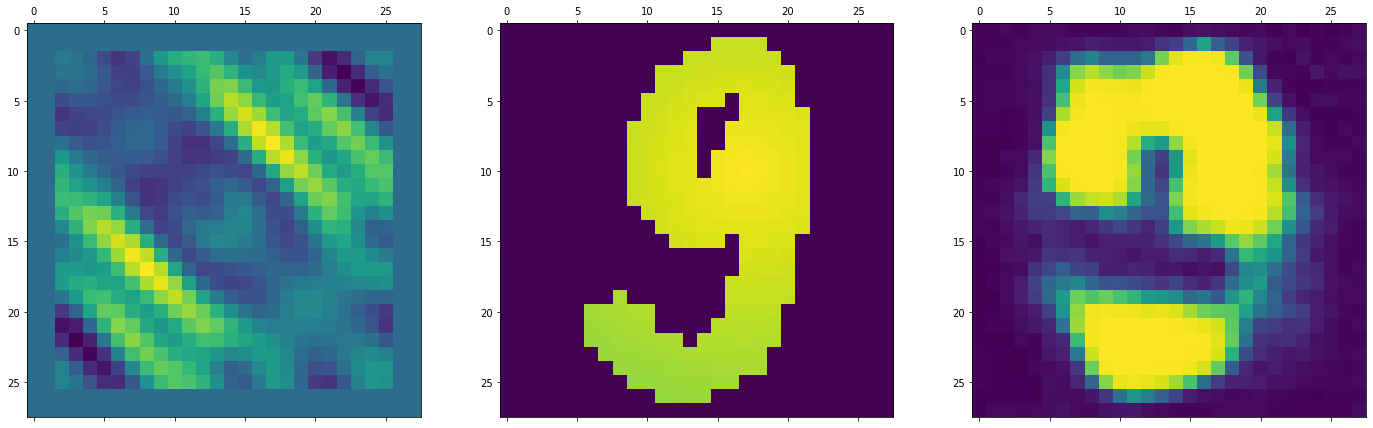

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(field_test_dif_perm[6])
axs[1].matshow(target_test_dif_perm[6])
axs[2].matshow(pred_dif_perm[6])

plt.show()

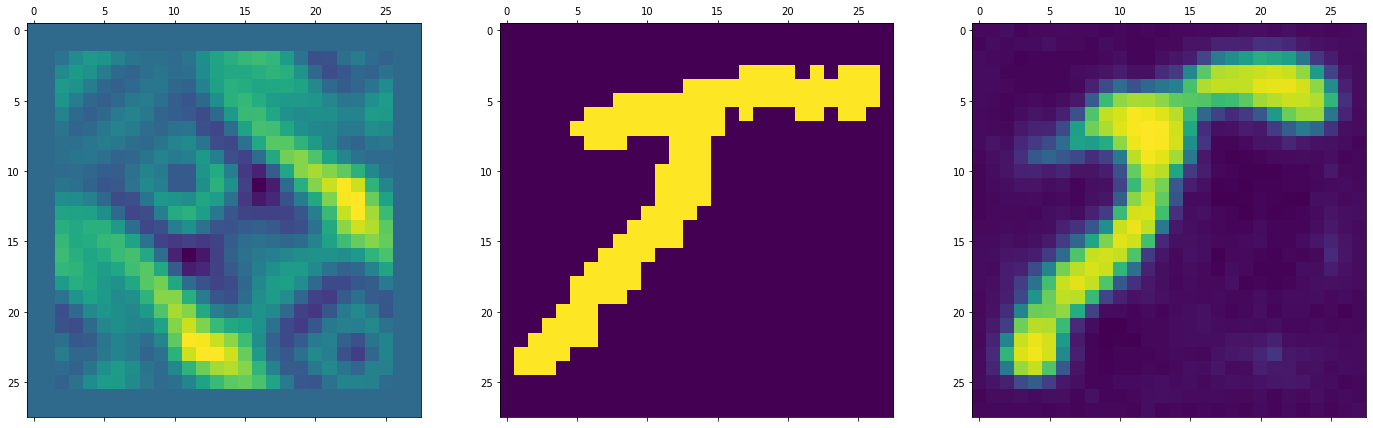

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_train_padded[30])
axs[1].matshow(targetMNIST_train[30])
axs[2].matshow(pred_train[30])

plt.show()

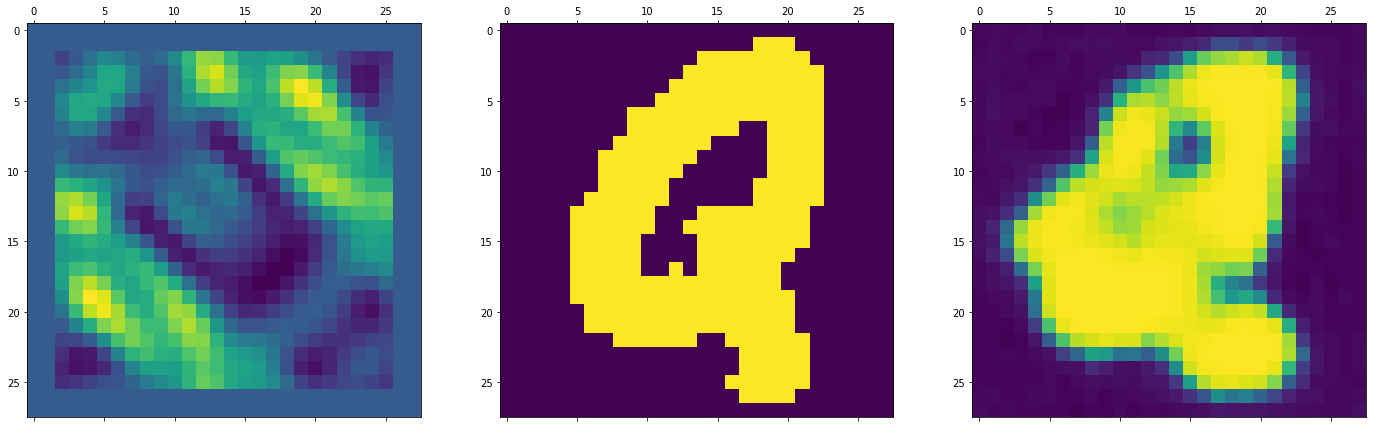

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test_padded[0])
axs[1].matshow(targetMNIST_test[0])
axs[2].matshow(pred_test[0])

plt.show()

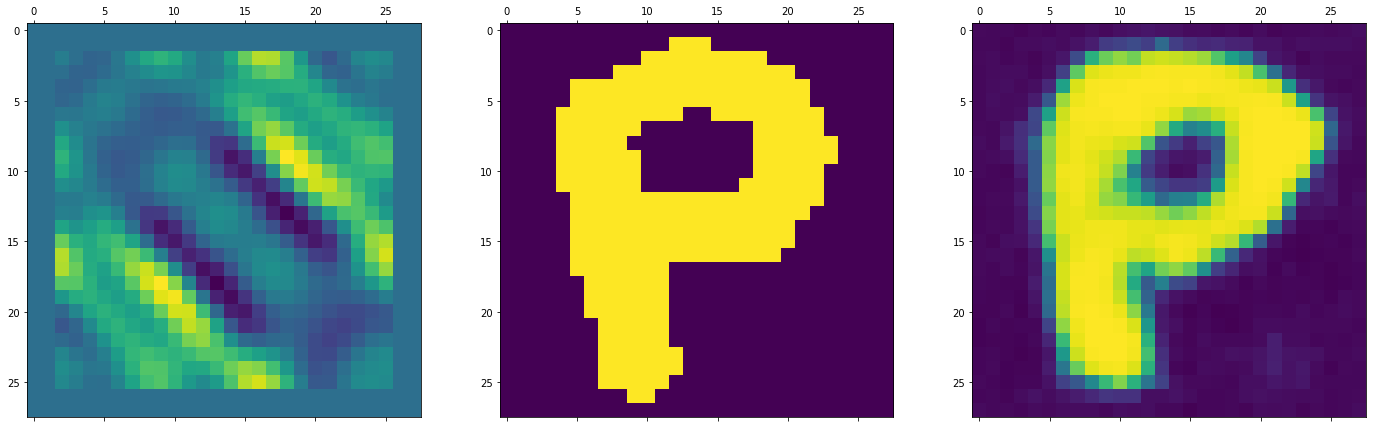

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test_padded[16])
axs[1].matshow(targetMNIST_test[16])
axs[2].matshow(pred_test[16])

plt.show()

In [99]:
best_model.evaluate(field_train_dif_perm, target_train_dif_perm)

16/16 [==============================] - 1s 67ms/step - loss: 0.3686 - accuracy: 0.5531


[0.36857539415359497, 0.5531437397003174]

In [12]:
# best_model.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 65ms/step - loss: 0.2861 - accuracy: 0.8877


[0.28608083724975586, 0.8876640200614929]

In [40]:
# best_model.evaluate(field_train_dif_perm, target_train_dif_perm)

16/16 [==============================] - 1s 58ms/step - loss: 0.3851 - accuracy: 0.5737


[0.38513436913490295, 0.5737037658691406]

UNET with Flatten Layer to output 28x28 image

In [86]:
def unet_with_flatten(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(28, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(56, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(56, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(128, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(128, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(56, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(56, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(56, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(28, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(28, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(28, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    flatten = Flatten()(conv4)

    dense = Dense(28*28*1, activation='relu')(flatten)

    reshape = Reshape((28, 28, 1))(dense)

    output = Conv2D(1, 1, activation='sigmoid')(reshape)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [100]:
kf1 = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
losses2 = []
val_losses2 = []
accuracy2 = []
val_accuracy2 = []
histories2 = []

acc_per_fold2 = []

   
Training for fold 1 ...
Epoch 1/80
41/41 [==============================] - 9s 148ms/step - loss: 0.6726 - accuracy: 0.7438 - val_loss: 0.6906 - val_accuracy: 0.7061 - lr: 2.0000e-04
Epoch 2/80
41/41 [==============================] - 6s 153ms/step - loss: 0.6288 - accuracy: 0.7924 - val_loss: 0.6886 - val_accuracy: 0.7031 - lr: 2.0000e-04
Epoch 3/80
41/41 [==============================] - 7s 166ms/step - loss: 0.6067 - accuracy: 0.8108 - val_loss: 0.6853 - val_accuracy: 0.7099 - lr: 2.0000e-04
Epoch 4/80
41/41 [==============================] - 7s 170ms/step - loss: 0.5921 - accuracy: 0.8208 - val_loss: 0.6834 - val_accuracy: 0.7068 - lr: 2.0000e-04
Epoch 5/80
41/41 [==============================] - 7s 166ms/step - loss: 0.5817 - accuracy: 0.8286 - val_loss: 0.6797 - val_accuracy: 0.7150 - lr: 2.0000e-04
Epoch 6/80
41/41 [==============================] - 7s 162ms/step - loss: 0.5731 - accuracy: 0.8347 - val_loss: 0.6772 - val_accuracy: 0.7204 - lr: 2.0000e-04
Epoch 7/80
41/41 [

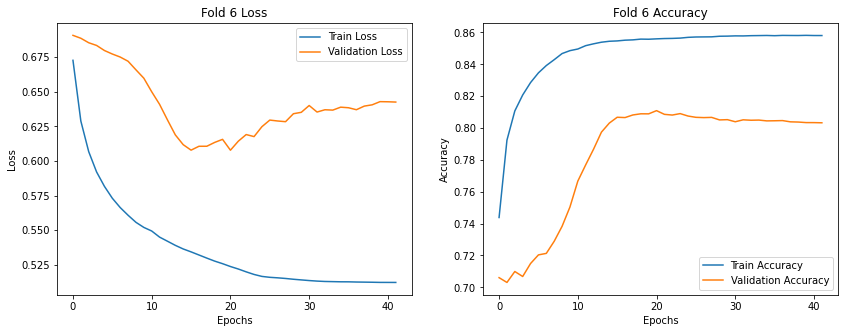

   
Training for fold 2 ...
Epoch 1/80
41/41 [==============================] - 15s 169ms/step - loss: 0.6735 - accuracy: 0.7396 - val_loss: 0.6897 - val_accuracy: 0.7037 - lr: 2.0000e-04
Epoch 2/80
41/41 [==============================] - 6s 154ms/step - loss: 0.6340 - accuracy: 0.7832 - val_loss: 0.6876 - val_accuracy: 0.7037 - lr: 2.0000e-04
Epoch 3/80
41/41 [==============================] - 7s 161ms/step - loss: 0.6141 - accuracy: 0.8018 - val_loss: 0.6857 - val_accuracy: 0.7043 - lr: 2.0000e-04
Epoch 4/80
41/41 [==============================] - 6s 156ms/step - loss: 0.5991 - accuracy: 0.8128 - val_loss: 0.6842 - val_accuracy: 0.7039 - lr: 2.0000e-04
Epoch 5/80
41/41 [==============================] - 7s 160ms/step - loss: 0.5892 - accuracy: 0.8194 - val_loss: 0.6827 - val_accuracy: 0.7064 - lr: 2.0000e-04
Epoch 6/80
41/41 [==============================] - 6s 152ms/step - loss: 0.5808 - accuracy: 0.8249 - val_loss: 0.6811 - val_accuracy: 0.7072 - lr: 2.0000e-04
Epoch 7/80
41/41 

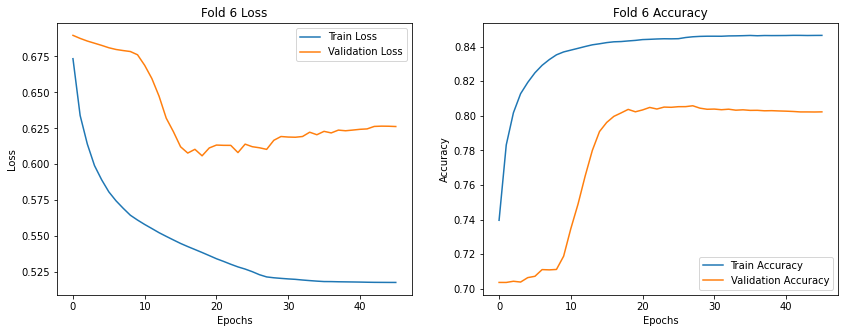

   
Training for fold 3 ...
Epoch 1/80
41/41 [==============================] - 9s 163ms/step - loss: 0.4777 - accuracy: 0.6882 - val_loss: 0.5706 - val_accuracy: 0.7384 - lr: 2.0000e-04
Epoch 2/80
41/41 [==============================] - 6s 159ms/step - loss: 0.4024 - accuracy: 0.8013 - val_loss: 0.5063 - val_accuracy: 0.7365 - lr: 2.0000e-04
Epoch 3/80
41/41 [==============================] - 7s 179ms/step - loss: 0.3730 - accuracy: 0.8276 - val_loss: 0.5065 - val_accuracy: 0.7366 - lr: 2.0000e-04
Epoch 4/80
41/41 [==============================] - 7s 167ms/step - loss: 0.3536 - accuracy: 0.8413 - val_loss: 0.5548 - val_accuracy: 0.7367 - lr: 2.0000e-04
Epoch 5/80
41/41 [==============================] - 7s 174ms/step - loss: 0.3404 - accuracy: 0.8529 - val_loss: 0.6480 - val_accuracy: 0.7360 - lr: 2.0000e-04
Epoch 6/80
41/41 [==============================] - 9s 227ms/step - loss: 0.3297 - accuracy: 0.8606 - val_loss: 0.7097 - val_accuracy: 0.7341 - lr: 2.0000e-04
Epoch 7/80
41/41 [

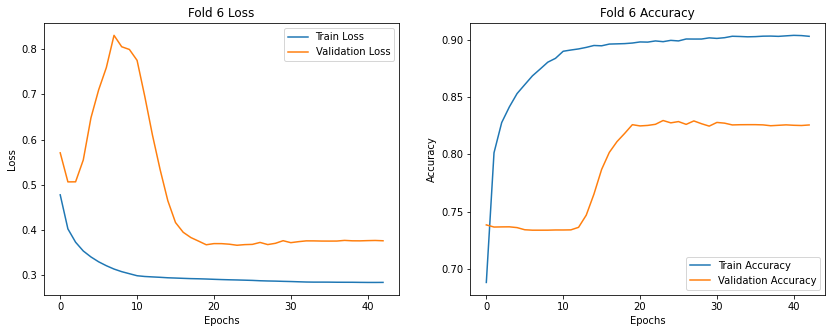

   
Training for fold 4 ...
Epoch 1/80
41/41 [==============================] - 9s 180ms/step - loss: 0.4737 - accuracy: 0.6934 - val_loss: 0.5552 - val_accuracy: 0.7458 - lr: 2.0000e-04
Epoch 2/80
41/41 [==============================] - 6s 156ms/step - loss: 0.4089 - accuracy: 0.7792 - val_loss: 0.4934 - val_accuracy: 0.7462 - lr: 2.0000e-04
Epoch 3/80
41/41 [==============================] - 6s 150ms/step - loss: 0.3854 - accuracy: 0.7946 - val_loss: 0.4868 - val_accuracy: 0.7443 - lr: 2.0000e-04
Epoch 4/80
41/41 [==============================] - 6s 151ms/step - loss: 0.3713 - accuracy: 0.8050 - val_loss: 0.5173 - val_accuracy: 0.7436 - lr: 2.0000e-04
Epoch 5/80
41/41 [==============================] - 6s 157ms/step - loss: 0.3604 - accuracy: 0.8144 - val_loss: 0.5644 - val_accuracy: 0.7418 - lr: 2.0000e-04
Epoch 6/80
41/41 [==============================] - 6s 142ms/step - loss: 0.3522 - accuracy: 0.8205 - val_loss: 0.6336 - val_accuracy: 0.7415 - lr: 2.0000e-04
Epoch 7/80
41/41 [

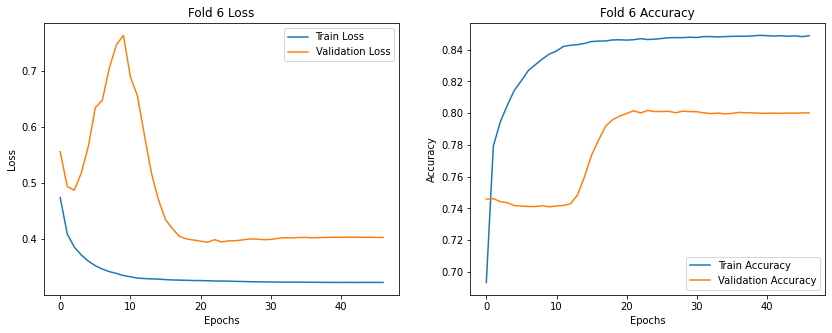

   
Training for fold 5 ...
Epoch 1/80
41/41 [==============================] - 10s 203ms/step - loss: 0.6713 - accuracy: 0.7493 - val_loss: 0.6905 - val_accuracy: 0.7261 - lr: 2.0000e-04
Epoch 2/80
41/41 [==============================] - 6s 155ms/step - loss: 0.6389 - accuracy: 0.7936 - val_loss: 0.6880 - val_accuracy: 0.7261 - lr: 2.0000e-04
Epoch 3/80
41/41 [==============================] - 6s 148ms/step - loss: 0.6164 - accuracy: 0.8182 - val_loss: 0.6867 - val_accuracy: 0.7177 - lr: 2.0000e-04
Epoch 4/80
41/41 [==============================] - 5s 133ms/step - loss: 0.5990 - accuracy: 0.8368 - val_loss: 0.6855 - val_accuracy: 0.7090 - lr: 2.0000e-04
Epoch 5/80
41/41 [==============================] - 6s 146ms/step - loss: 0.5837 - accuracy: 0.8504 - val_loss: 0.6842 - val_accuracy: 0.7025 - lr: 2.0000e-04
Epoch 6/80
41/41 [==============================] - 5s 132ms/step - loss: 0.5712 - accuracy: 0.8598 - val_loss: 0.6795 - val_accuracy: 0.7258 - lr: 2.0000e-04
Epoch 7/80
41/41 

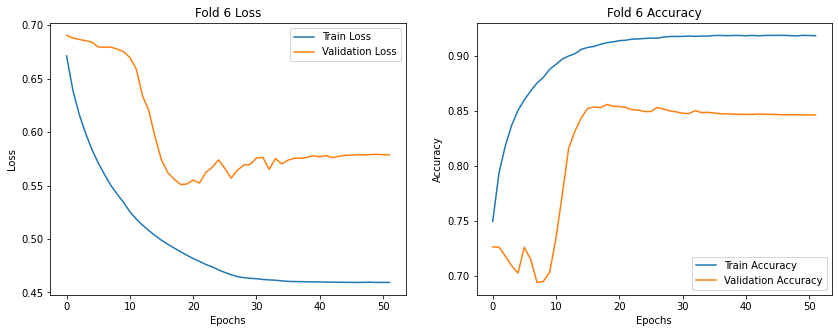

In [101]:
for train_index, val_index in kf1.split(fieldMNIST_train_full):
    print('   ')
    print(f'Training for fold {fold_no} ...')

    X_train, X_val = fieldMNIST_train_full[train_index], fieldMNIST_train_full[val_index]
    y_train, y_val = targetMNIST_train_full[train_index], targetMNIST_train_full[val_index]


    model2 = unet_with_flatten(input_shape=X_train.shape[1:])

    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics='accuracy')
    early_stopping = EarlyStopping(monitor='loss', patience=10,min_delta=0.001)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_delta=0.0001, min_lr=1e-9)
    # checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
    history = model2.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=80, 
                        batch_size=10,
                        callbacks=[early_stopping,reduce_lr])
    histories2.append(history.history)

        #Save model trained on each fold.
    model2.save('models_flatten/model_fold_'+str(fold_no)+'.h5')   

    # Evaluate the model - repor accuracy and capture it into a list for future reporting
    scores2 = model2.evaluate(fieldMNIST_test, targetMNIST_test, verbose=0)
    acc_per_fold2.append(scores2[1] * 100)

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

    losses2.append((history.history['loss']))
    val_losses2.append((history.history['val_loss']))
    accuracy2.append((history.history['accuracy']))
    val_accuracy2.append((history.history['val_accuracy']))

    fold_no += 1

In [102]:
acc_per_fold2

[80.86228370666504,
 80.44217824935913,
 83.01445841789246,
 79.30434346199036,
 85.08665561676025]

In [103]:
best_model_flatten = load_model('models_flatten/model_fold_5.h5')
pred_test_flatten = best_model_flatten.predict(fieldMNIST_test)
pred_train_flatten = best_model_flatten.predict(fieldMNIST_train_full)
pred_dif_perm_flatten = best_model_flatten.predict(field_dif_perm_transformed)

20/20 [==============================] - 1s 47ms/step


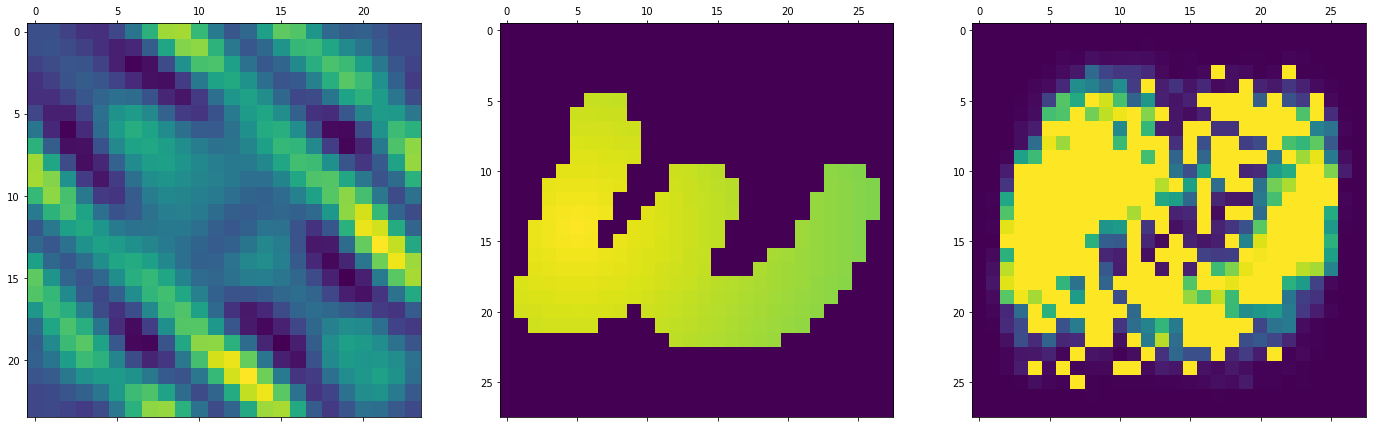

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))
i = 20
axs[0].matshow(field_dif_perm_transformed[i])
axs[1].matshow(target_dif_perm_transformed[i])
axs[2].matshow(pred_dif_perm_flatten[i])

plt.show()

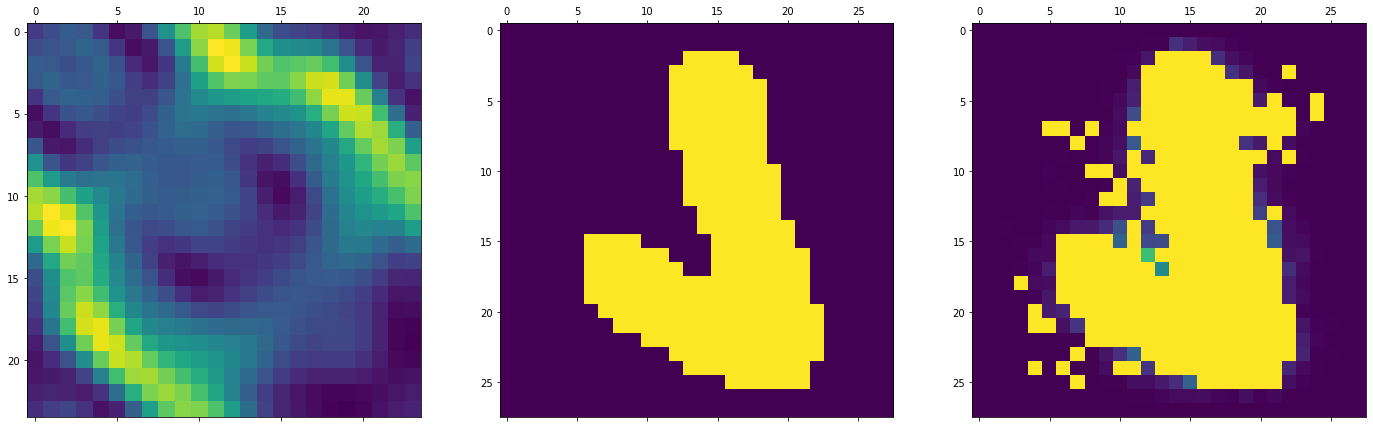

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_train_full[20])
axs[1].matshow(targetMNIST_train_full[20])
axs[2].matshow(pred_train_flatten[20])

plt.show()

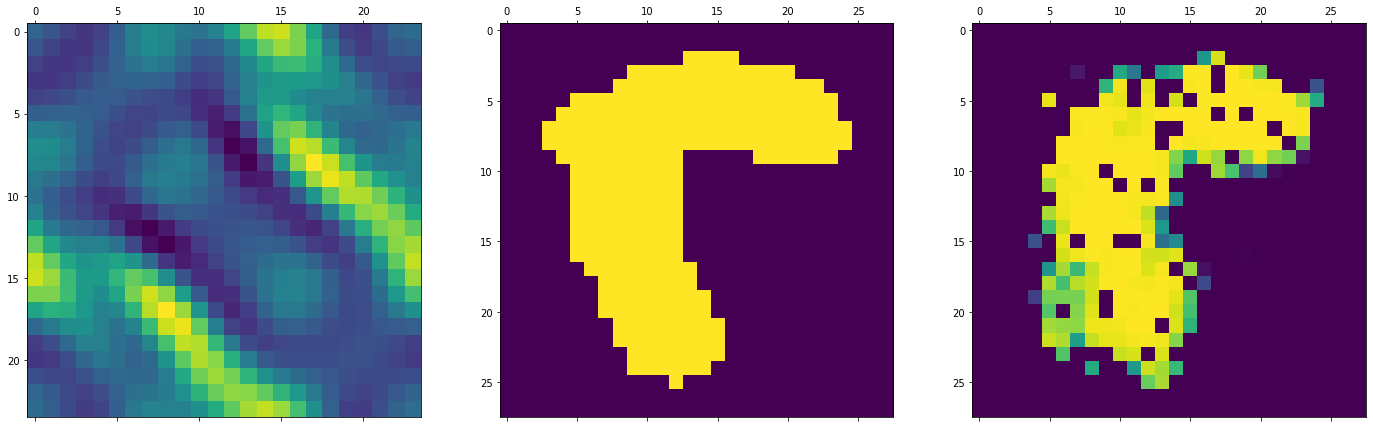

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[40])
axs[1].matshow(targetMNIST_test[40])
axs[2].matshow(pred_test_flatten[40])

plt.show()

In [42]:
best_model_flatten.evaluate(fieldMNIST_test, targetMNIST_test)

4/4 [==============================] - 1s 59ms/step - loss: 0.3553 - accuracy: 0.8428


[0.3553360402584076, 0.8427579402923584]

In [111]:
best_model_flatten.evaluate(fieldMNIST_test, targetMNIST_test)

4/4 [==============================] - 1s 58ms/step - loss: 0.5897 - accuracy: 0.8509


[0.5896572470664978, 0.8508665561676025]

In [108]:
field_dif_perm_transformed.shape

(630, 24, 24, 1)